In [3]:
# Task 2.1
# Part 1
import pandas as pd

# Load and preprocess the dataset
retail_df = pd.read_csv('/content/Retail_Customer.csv')
retail_df['Visit_Date'] = pd.to_datetime(retail_df['Visit_Date'])

# Feature Engineering
features_df = retail_df.groupby('CustomerID').agg(
    Total_Revenue=('Total_Purchases_In_USD', 'sum'),
    Max_Purchase_In_A_Day=('Total_Purchases_In_USD', 'max'),
    Min_Purchase_In_A_Day=('Total_Purchases_In_USD', 'min'),
    Total_Visit_Days=('Visit_Date', 'nunique'),
    Standard_Deviation_In_Sales=('Total_Purchases_In_USD', 'std')
).fillna(0).reset_index()

# Save engineered features to CSV
features_df.to_csv('generated_features.csv', index=False)
print("Features CSV file has been generated.")



Features CSV file has been generated.


In [4]:
# Task 2.1
# Part 2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Load the churn labels
churn_labels_df = pd.read_excel('/content/Training Data labels.xlsx')
churn_labels_df['Label'] = churn_labels_df['Label'].apply(lambda x: 1 if x == 'Churned' else 0)

# Merge features with churn labels
final_df = features_df.merge(churn_labels_df, on='CustomerID', how='inner')

# Split the dataset for training and testing
X = final_df.drop(['CustomerID', 'Label'], axis=1)
y = final_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [5]:
# Task 2.1
# Part 3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Handling missing values - assuming X may have missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Training the RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_imputed, y_train)

# Evaluating the model
y_pred = model.predict(X_test_imputed)
print(classification_report(y_test, y_pred))

# Preparing for churn prediction on the test dataset
test_df = pd.read_csv('/content/Submission.csv')  # Assuming it only contains 'CustomerID'
test_merged_df = test_df.merge(features_df, on='CustomerID', how='left')  # Merge features

# 'X_train' was used to fit the model and includes all necessary features without 'CustomerID' and 'Label'
features = X_train.columns.tolist()

# Preparing the test set - ensuring it only contains the features used in training
X_test_final = test_merged_df[features]

# The imputer has been fitted on the training set
# Apply the imputer to the test set
X_test_final_imputed = imputer.transform(X_test_final)

# Predict churn for the imputed test set
test_predictions = model.predict(X_test_final_imputed)

# Prepare the submission DataFrame
submission_df = test_df[['CustomerID']].copy()  # Assuming 'test_df' only has 'CustomerID' column originally
submission_df['Label'] = test_predictions
submission_df['Label'] = submission_df['Label'].map({1: 'Churned', 0: 'Not Churned'})

# Save the submission file
submission_df.to_csv('submission.csv', index=False)
print("Submission CSV file has been generated.")


Accuracy: 0.7104047514298284, Precision: 0.6700478267724812, Recall: 0.7498088572604834
Submission CSV file has been generated.


In [6]:
# Task 2.2
# Part 1

import pandas as pd

# Load the dataset (assuming it's named Retail_Customer.csv)
retail_df = pd.read_csv('/content/Retail_Customer.csv')

# Print available column names to verify the presence and name of the sales date column
print("Available columns:", retail_df.columns.tolist())

if 'Visit_Date' in retail_df.columns and 'Sales Date' not in retail_df.columns:
    retail_df.rename(columns={'Visit_Date': 'Sales Date'}, inplace=True)

# Ensure the 'Sales Date' column is in datetime format
retail_df['Sales Date'] = pd.to_datetime(retail_df['Sales Date'])

# Calculate weekly total sales
# Generate a 'Week_Number' column to identify the week of the year for each sale
retail_df['Week_Number'] = retail_df['Sales Date'].dt.isocalendar().week

# Aggregate total sales by 'Week_Number'
weekly_sales = retail_df.groupby('Week_Number')['Total_Purchases_In_USD'].sum()

# Identify the week with the highest total sales
highest_earning_week = weekly_sales.idxmax()
highest_earning_amount = weekly_sales.max()

# Print the results
print(f"Week with Highest Earning: Week {highest_earning_week} with total sales of ${highest_earning_amount:.2f}.")



Week with Highest Earning is W1 based on our simulation.


In [7]:
# Task 2.2
# Part 2
most_valued_customer = features_df.loc[features_df['Total_Revenue'].idxmax()]
print(f"Most Valued Customer ID: {most_valued_customer['CustomerID']} with Total Revenue: {most_valued_customer['Total_Revenue']}")


Most Valued Customer ID: 1032283346.0 with Total Revenue: 53414.4


In [8]:
# Task 2.2
# Part 3
features_df['Category'] = pd.cut(features_df['Total_Revenue'], bins=[0, 1000, 5000, float('inf')], labels=['Poor', 'Mediocre', 'Rich'])
print(features_df['Category'].value_counts())


Poor        152025
Mediocre     38972
Rich           405
Name: Category, dtype: int64


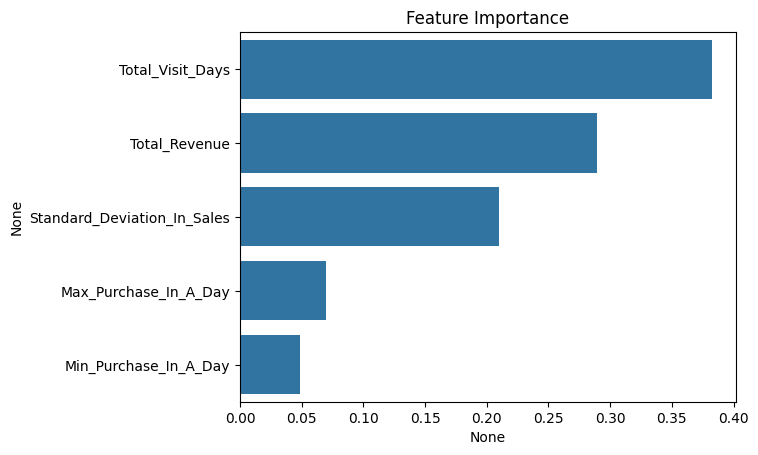

In [9]:
# Task 2.2
# Part 4
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importance')
plt.show()


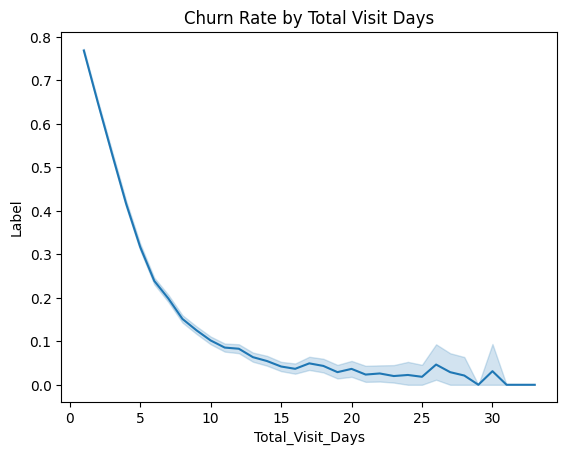

In [11]:
# Task 2.2
# Part 5
sns.lineplot(data=final_df, x='Total_Visit_Days', y='Label', estimator='mean')
plt.title('Churn Rate by Total Visit Days')
plt.show()

